In [ ]:
pip install lightgbm

In [3]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 2.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 6.8 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 10.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 6.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 1.9 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np
import optuna

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from precision_recall_cutoff import precision_recall_cutoff

In [16]:
# importing data 
s3 = boto3.resource('s3')
bucket_name = 'grant-gonnerman-data-445'
bucket = s3.Bucket(bucket_name)

file_key = 'BankChurners.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# reading data file
churn = pd.read_csv(file_content_stream)
churn.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


# EDA

In [3]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

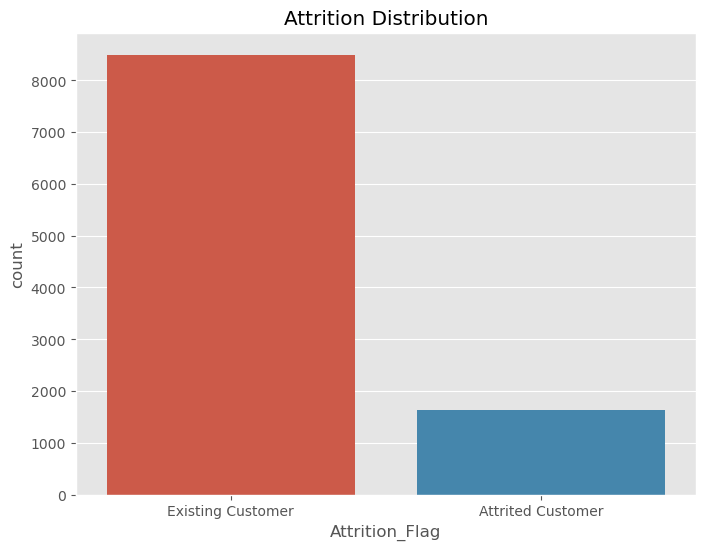

In [28]:
plt.figure(figsize = (8, 6))
sns.countplot(x = 'Attrition_Flag', data = churn).set(title = 'Attrition Distribution');

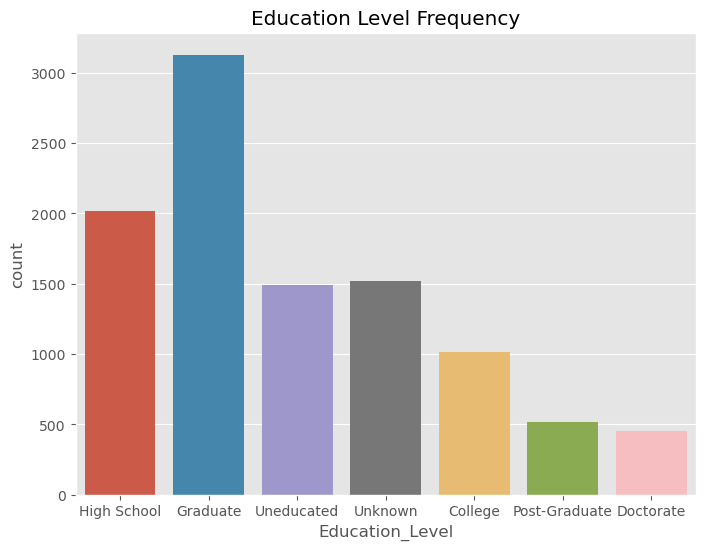

In [6]:
plt.figure(figsize = (8, 6))
sns.countplot(x = 'Education_Level', data = churn).set(title = 'Education Level Frequency');

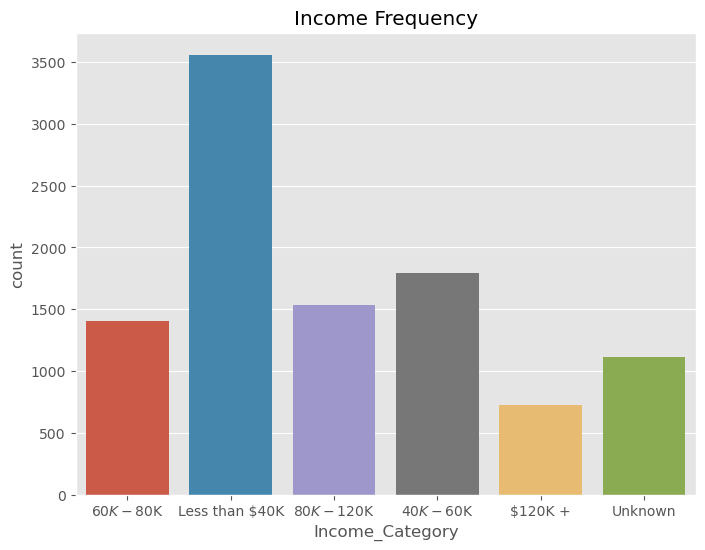

In [7]:
plt.figure(figsize = (8, 6))
sns.countplot(x = 'Income_Category', data = churn).set(title = 'Income Frequency');

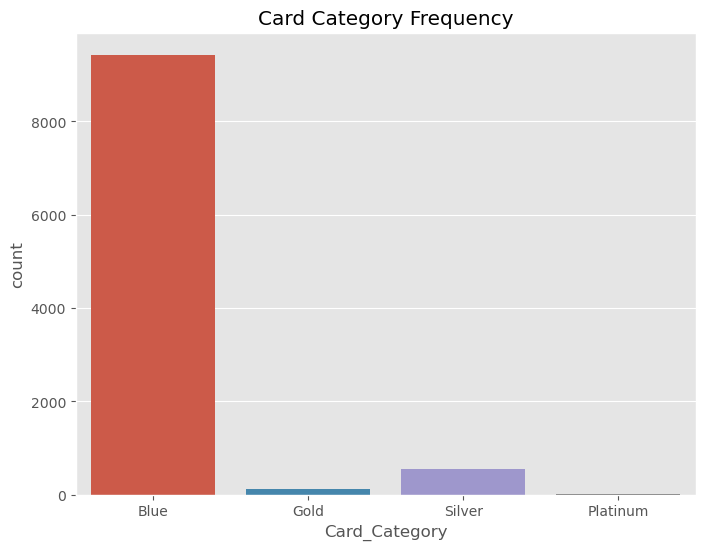

In [8]:
plt.figure(figsize = (8, 6))
sns.countplot(x = 'Card_Category', data = churn).set(title = 'Card Category Frequency');

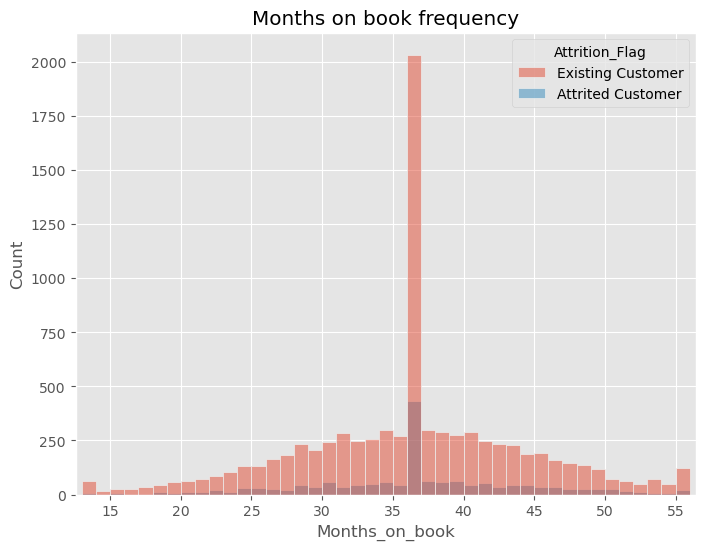

In [50]:
plt.figure(figsize = (8, 6))
sns.histplot(x = 'Months_on_book', data = churn, binwidth = 1, hue = 'Attrition_Flag').set(title = 'Months on book frequency');
plt.margins(x=0.01)
plt.show()

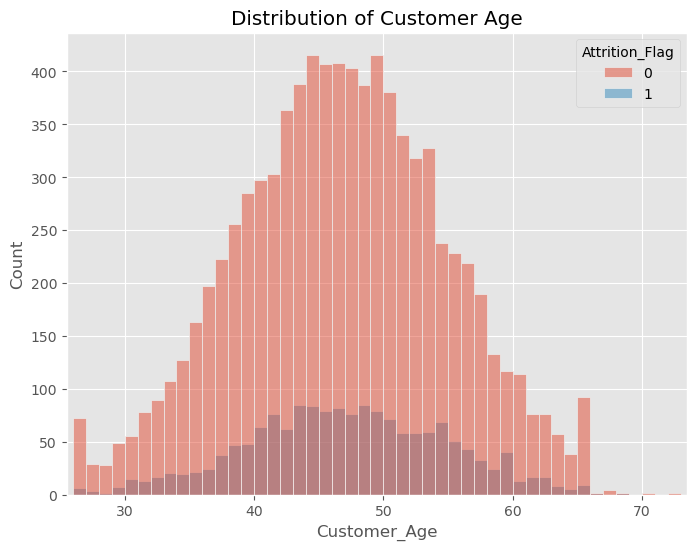

In [30]:
plt.figure(figsize = (8, 6))
sns.histplot(x = 'Customer_Age', data = churn, hue = 'Attrition_Flag').set(title = 'Distribution of Customer Age');
plt.margins(x=0.01)

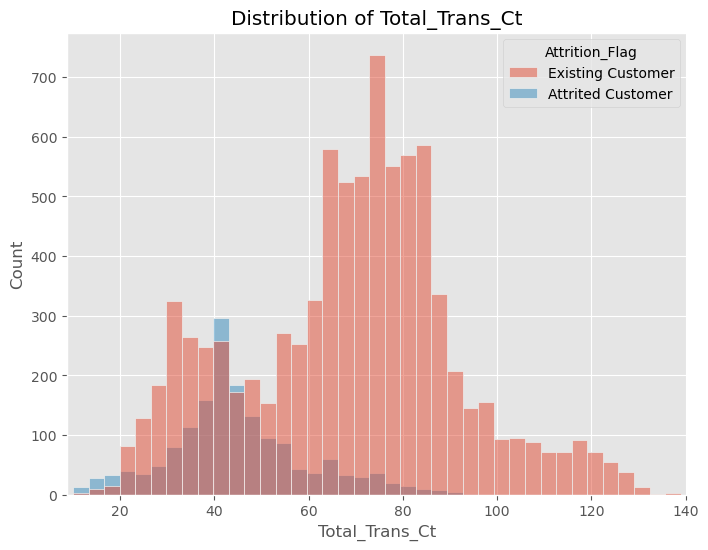

In [43]:
plt.figure(figsize = (8, 6))
sns.histplot(x = 'Total_Trans_Ct', data = churn, hue = 'Attrition_Flag').set(title = 'Distribution of Total_Trans_Ct');
plt.margins(x=0.01)

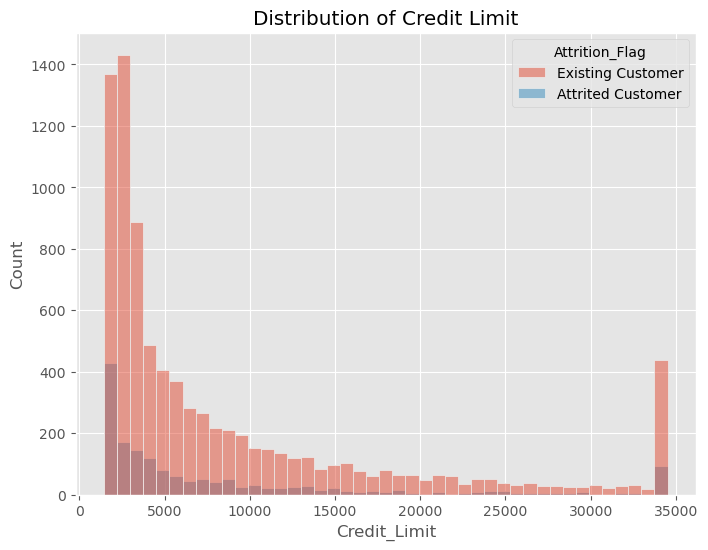

In [44]:
plt.figure(figsize = (8, 6))
sns.histplot(x = 'Credit_Limit', data = churn, hue = 'Attrition_Flag').set(title = 'Distribution of Credit Limit');

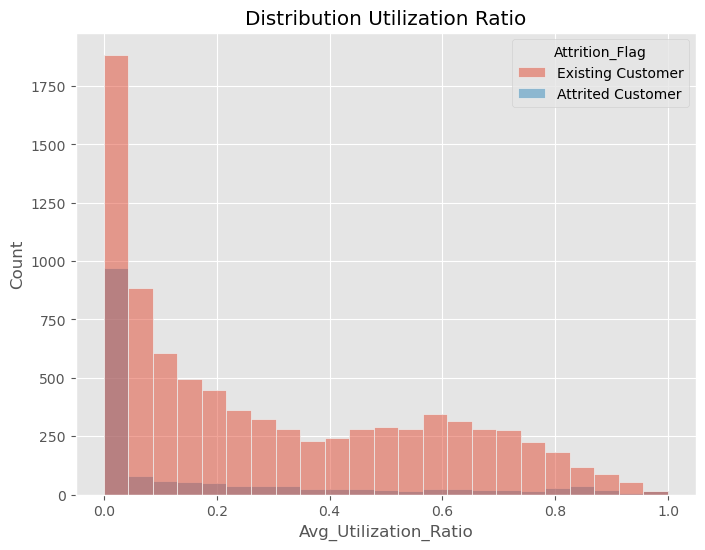

In [45]:
plt.figure(figsize = (8, 6))
sns.histplot(x = 'Avg_Utilization_Ratio', data = churn, hue = 'Attrition_Flag').set(title = 'Distribution Utilization Ratio');

/tmp/ipykernel_22949/4237036644.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = churn.corr()


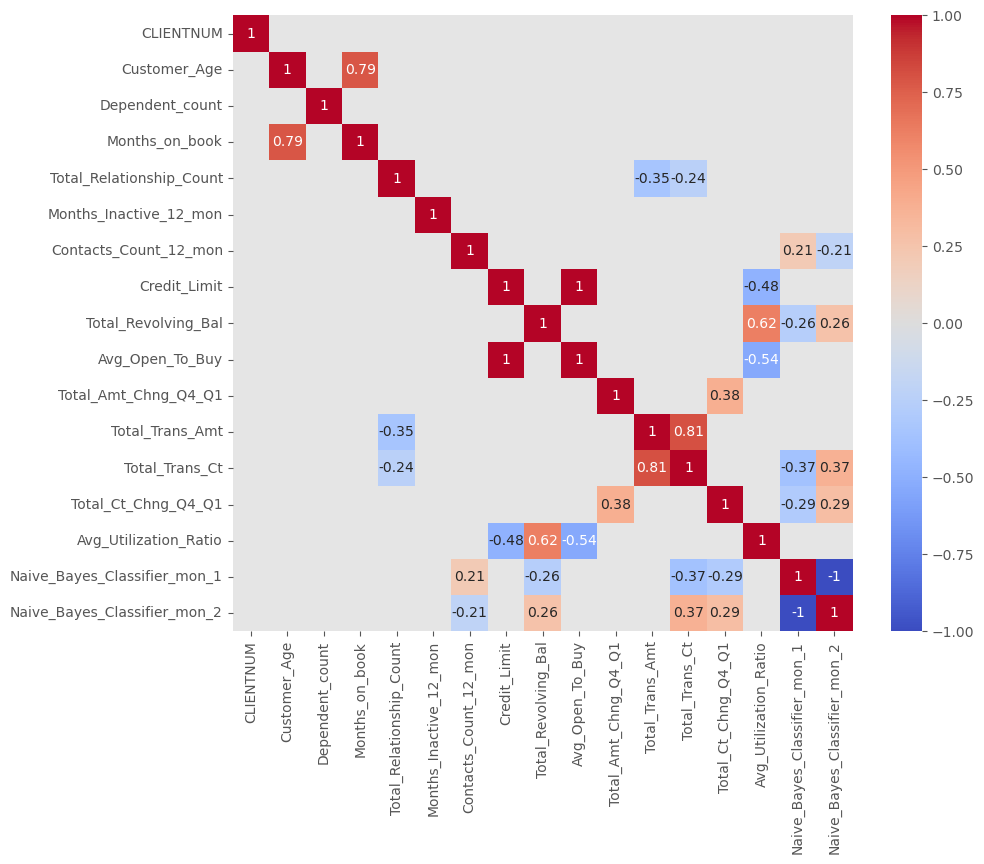

In [51]:
corr_matrix = churn.corr()
corr_filtered = corr_matrix[np.abs(corr_matrix) > 0.2]
# Create a heatmap
plt.figure(figsize = (10, 8))
sns.heatmap(corr_filtered, cmap='coolwarm', annot = True);

Customer_Age * Months_on_book | Total_Revolving_bal * Avg_Utilization_Ratio | Total_Trans_Amt * Total_Trans_Ct | Avg_Utilization_Ratio * Avg_Open_To_Buy 

# Data Preparation

In [17]:
churn['Attrition_Flag'] = np.where(churn['Attrition_Flag'] == 'Existing Customer', 0, 1)
churn['Gender'] = np.where(churn['Gender'] == 'M', 0, 1)
churn = pd.concat([churn.drop(columns = ['Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category'], axis =  1 ), 
                   pd.get_dummies(churn[['Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']])], axis = 1)
churn = churn.drop(columns = churn[['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']], axis = 1)
churn.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Education_Level_College,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Education_Level_Unknown,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,768805383,0,45,0,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
1,818770008,0,49,1,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
2,713982108,0,51,0,3,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
3,769911858,0,40,1,4,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
4,709106358,0,40,0,3,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0


# Baseline Modeling

In [10]:
## Defining inputs and target
x = churn.drop(columns = 'Attrition_Flag', axis = 1)
y = churn['Attrition_Flag']

In [9]:
recall, precision, accuracy = list(), list(), list()
recall_scores, precision_scores, accuracy_scores = list(), list(), list()

## Running 5 times CV
for i in range(5):
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(x, y):
        
        ## Splitting the data 
        x_train, x_test = x.iloc[train_ix], x.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    
        ## Building RF model
        rf_md = RandomForestClassifier(n_estimators = 300, max_depth = 10).fit(x_train, y_train)
        
        ## Predicting on X_test and test
        rf_pred = rf_md.predict_proba(x_test)[:, 1]
        
        ## changing likilyhoods to labels
        rf_label = precision_recall_cutoff(y_test, rf_pred)
        
        ## Computing metrics
        recall.append(recall_score(rf_label, y_test))
        precision.append(precision_score(rf_label, y_test))
        accuracy.append(accuracy_score(rf_label, y_test))
        
    recall_scores.append(np.mean(recall))
    precision_scores.append(np.mean(precision))
    accuracy_scores.append(np.mean(accuracy))

recall_cv_score = np.mean(recall_scores)
precision_cv_score = np.mean(precision_scores)   
accuracy_cv_score = np.mean(accuracy_scores)   
print('The recall score over 5-folds (run 5 times) is:', recall_cv_score)
print('The precision score over 5-folds (run 5 times) is:', precision_cv_score)
print('The accuracy score over 5-folds (run 5 times) is:', accuracy_cv_score)

The recall score over 5-folds (run 5 times) is: 0.8656613016792525
The precision score over 5-folds (run 5 times) is: 0.8735030171464526
The accuracy score over 5-folds (run 5 times) is: 0.9578003274306444


In [10]:
recall, precision, accuracy = list(), list(), list()
recall_scores, precision_scores, accuracy_scores = list(), list(), list()

## Running 5 times CV
for i in range(5):
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(x, y):
        
        ## Splitting the data 
        x_train, x_test = x.iloc[train_ix], x.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    
        ## Building ada model
        ada_md = AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth = 3), n_estimators = 583, learning_rate = .08).fit(x_train, y_train)
        
        ## Predicting on X_test and test
        ada_pred = ada_md.predict_proba(x_test)[:, 1]
        
        ## changing likilyhoods to labels
        ada_label = precision_recall_cutoff(y_test, ada_pred)
        
        ## Computing metrics
        recall.append(recall_score(ada_label, y_test))
        precision.append(precision_score(ada_label, y_test))
        accuracy.append(accuracy_score(ada_label, y_test))
        
    recall_scores.append(np.mean(recall))
    precision_scores.append(np.mean(precision))
    accuracy_scores.append(np.mean(accuracy))

recall_cv_score = np.mean(recall_scores)
precision_cv_score = np.mean(precision_scores)   
accuracy_cv_score = np.mean(accuracy_scores)   
print('The recall score over 5-folds (run 5 times) is:', recall_cv_score)
print('The precision score over 5-folds (run 5 times) is:', precision_cv_score)
print('The accuracy score over 5-folds (run 5 times) is:', accuracy_cv_score)

The recall score over 5-folds (run 5 times) is: 0.9210403548181155
The precision score over 5-folds (run 5 times) is: 0.9213223281422055
The accuracy score over 5-folds (run 5 times) is: 0.9746528614432135


In [18]:
recall, precision, accuracy = list(), list(), list()
recall_scores, precision_scores, accuracy_scores = list(), list(), list()

## Running 5 times CV
for i in range(5):
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(x, y):
        
        ## Splitting the data 
        x_train, x_test = x.iloc[train_ix], x.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    
        ## Building gb model
        gb_md = GradientBoostingClassifier(max_depth = 4, n_estimators = 500, learning_rate = .08).fit(x_train, y_train)
        
        ## Predicting on X_test and test
        gb_pred = gb_md.predict_proba(x_test)[:, 1]
        
        ## changing likilyhoods to labels
        gb_label = precision_recall_cutoff(y_test, gb_pred)
        
        ## Computing metrics
        recall.append(recall_score(gb_label, y_test))
        precision.append(precision_score(gb_label, y_test))
        accuracy.append(accuracy_score(gb_label, y_test))
        
    recall_scores.append(np.mean(recall))
    precision_scores.append(np.mean(precision))
    accuracy_scores.append(np.mean(accuracy))

recall_cv_score = np.mean(recall_scores)
precision_cv_score = np.mean(precision_scores)   
accuracy_cv_score = np.mean(accuracy_scores)   
print('The recall score over 5-folds (run 5 times) is:', recall_cv_score)
print('The precision score over 5-folds (run 5 times) is:', precision_cv_score)
print('The accuracy score over 5-folds (run 5 times) is:', accuracy_cv_score)

The recall score over 5-folds (run 5 times) is: 0.914749546349053
The precision score over 5-folds (run 5 times) is: 0.9147820355513607
The accuracy score over 5-folds (run 5 times) is: 0.9725448247677313


In [19]:
recall, precision, accuracy = list(), list(), list()
recall_scores, precision_scores, accuracy_scores = list(), list(), list()

## Running 5 times CV
for i in range(5):
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(x, y):
        
        ## Splitting the data 
        x_train, x_test = x.iloc[train_ix], x.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    
        ## Building hgb model
        hgb_md = HistGradientBoostingClassifier(max_iter = 317,
                                                learning_rate = 0.02,
                                                l2_regularization = 0.08,
                                                min_samples_leaf = 13, 
                                                max_leaf_nodes = 187,
                                                max_depth = 10,
                                                max_bins = 193,
                                                early_stopping = False).fit(x_train, y_train)
        
        ## Predicting on X_test and test
        hgb_pred = hgb_md.predict_proba(x_test)[:, 1]
        
        ## changing likilyhoods to labels
        hgb_label = precision_recall_cutoff(y_test, hgb_pred)
        
        ## Computing metrics
        recall.append(recall_score(hgb_label, y_test))
        precision.append(precision_score(hgb_label, y_test))
        accuracy.append(accuracy_score(hgb_label, y_test))
        
    recall_scores.append(np.mean(recall))
    precision_scores.append(np.mean(precision))
    accuracy_scores.append(np.mean(accuracy))

recall_cv_score = np.mean(recall_scores)
precision_cv_score = np.mean(precision_scores)   
accuracy_cv_score = np.mean(accuracy_scores)   
print('The recall score over 5-folds (run 5 times) is:', recall_cv_score)
print('The precision score over 5-folds (run 5 times) is:', precision_cv_score)
print('The accuracy score over 5-folds (run 5 times) is:', accuracy_cv_score)

The recall score over 5-folds (run 5 times) is: 0.9211551095914103
The precision score over 5-folds (run 5 times) is: 0.8967437470504954
The accuracy score over 5-folds (run 5 times) is: 0.9710672857787038


In [20]:
recall, precision, accuracy = list(), list(), list()
recall_scores, precision_scores, accuracy_scores = list(), list(), list()

## Running 5 times CV
for i in range(5):
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(x, y):
        
        ## Splitting the data 
        x_train, x_test = x.iloc[train_ix], x.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    
        ## Building xgb model
        xgb_md = XGBClassifier(learning_rate = 0.02,
                               n_estimators = 693, 
                               max_depth = 8, 
                               min_child_weight =  5,
                               gamma = 0.0012802215747381317, 
                               alpha = 0.0160209565269223, 
                               colsample_bytree = 0.7137141791291234,
                               subsample = 0.6687299521994856).fit(x_train, y_train)
        
        ## Predicting on X_test and test
        xgb_pred = xgb_md.predict_proba(x_test)[:, 1]
        
        ## changing likilyhoods to labels
        xgb_label = precision_recall_cutoff(y_test, xgb_pred)
        
        ## Computing metrics
        recall.append(recall_score(xgb_label, y_test))
        precision.append(precision_score(xgb_label, y_test))
        accuracy.append(accuracy_score(xgb_label, y_test))
        
    recall_scores.append(np.mean(recall))
    precision_scores.append(np.mean(precision))
    accuracy_scores.append(np.mean(accuracy))

recall_cv_score = np.mean(recall_scores)
precision_cv_score = np.mean(precision_scores)   
accuracy_cv_score = np.mean(accuracy_scores)   
print('The recall score over 5-folds (run 5 times) is:', recall_cv_score)
print('The precision score over 5-folds (run 5 times) is:', precision_cv_score)
print('The accuracy score over 5-folds (run 5 times) is:', accuracy_cv_score)

The recall score over 5-folds (run 5 times) is: 0.9066701545488304
The precision score over 5-folds (run 5 times) is: 0.923803680981595
The accuracy score over 5-folds (run 5 times) is: 0.972449904330128


In [11]:
recall, precision, accuracy = list(), list(), list()
recall_scores, precision_scores, accuracy_scores = list(), list(), list()

## Running 5 times CV
for i in range(5):
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(x, y):
        
        ## Splitting the data 
        x_train, x_test = x.iloc[train_ix], x.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    
        ## Building lgb model
        lgb_md = LGBMClassifier(n_estimators = 914,
                                max_depth = 5,
                                learning_rate = 0.08,
                                num_leaves = 554,
                                lambda_l1 = 0.18580590339387681,
                                lambda_l2 = 1.4332184061712825,
                                bagging_fraction = 0.521511113477117,
                                feature_fraction = 0.5745813618224658,
                                min_data_in_leaf = 88,
                                min_child_weight = 0.0012573816898813492).fit(x_train, y_train)
        
        ## Predicting on X_test and test
        lgb_pred = lgb_md.predict_proba(x_test)[:, 1]
        
        ## changing likilyhoods to labels
        lgb_label = precision_recall_cutoff(y_test, lgb_pred)
        
        ## Computing metrics
        recall.append(recall_score(lgb_label, y_test))
        precision.append(precision_score(lgb_label, y_test))
        accuracy.append(accuracy_score(lgb_label, y_test))
        
    recall_scores.append(np.mean(recall))
    precision_scores.append(np.mean(precision))
    accuracy_scores.append(np.mean(accuracy))
clear_output()
recall_cv_score = np.mean(recall_scores)
precision_cv_score = np.mean(precision_scores)   
accuracy_cv_score = np.mean(accuracy_scores)   
print('The recall score over 5-folds (run 5 times) is:', recall_cv_score)
print('The precision score over 5-folds (run 5 times) is:', precision_cv_score)
print('The accuracy score over 5-folds (run 5 times) is:', accuracy_cv_score)

The recall score over 5-folds (run 5 times) is: 0.9160621751353094
The precision score over 5-folds (run 5 times) is: 0.9170287871637564
The accuracy score over 5-folds (run 5 times) is: 0.9731413111037988


In [53]:
recall, precision, accuracy = list(), list(), list()
recall_scores, precision_scores, accuracy_scores = list(), list(), list()

## Running 5 times CV
for i in range(5):
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(x, y):
        
        ## Splitting the data 
        x_train, x_test = x.iloc[train_ix], x.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    
        ## Building cat model
        cat_md = CatBoostClassifier(iterations = 949,
                                   learning_rate = 0.05,
                                   min_data_in_leaf = 88,
                                   depth = 10,
                                   random_strength = 0.15071467136488892,
                                   bagging_temperature = 0.27778450622362905,
                                   border_count = 99,
                                   l2_leaf_reg = 56,
                                   verbose = False).fit(x_train, y_train)
        
        ## Predicting on X_test and test
        cat_pred = cat_md.predict_proba(x_test)[:, 1]
        
        ## changing likilyhoods to labels
        cat_label = precision_recall_cutoff(y_test, cat_pred)
        
        ## Computing metrics
        recall.append(recall_score(cat_label, y_test))
        precision.append(precision_score(cat_label, y_test))
        accuracy.append(accuracy_score(cat_label, y_test))
        
    recall_scores.append(np.mean(recall))
    precision_scores.append(np.mean(precision))
    accuracy_scores.append(np.mean(accuracy))

recall_cv_score = np.mean(recall_scores)
precision_cv_score = np.mean(precision_scores)   
accuracy_cv_score = np.mean(accuracy_scores)   
print('The recall score over 5-folds (run 5 times) is:', recall_cv_score)
print('The precision score over 5-folds (run 5 times) is:', precision_cv_score)
print('The accuracy score over 5-folds (run 5 times) is:', accuracy_cv_score)

The recall score over 5-folds (run 5 times) is: 0.9346975955067375
The precision score over 5-folds (run 5 times) is: 0.9133364794714488
The accuracy score over 5-folds (run 5 times) is: 0.9758071977867964


# Feature engineering

In [26]:
churn['interaction_1'] = churn['Customer_Age'] * churn['Months_on_book'] 
churn['interaction_2'] = churn['Total_Revolving_Bal'] * churn['Avg_Utilization_Ratio'] 
churn['interaction_3'] = churn['Total_Trans_Amt'] * churn['Total_Trans_Ct'] 
churn['interaction_4'] = churn['Avg_Utilization_Ratio'] * churn['Avg_Open_To_Buy'] 
churn['Months_on_book_36_flag'] = np.where(churn['Months_on_book'] == 36, 1, 0)
churn['Credit_Limit_max_flag'] = np.where(churn['Credit_Limit'] == 34516.0, 1, 0)
churn['Total_Revolving_Bal_0_flag'] = np.where(churn['Total_Revolving_Bal'] == 0, 1, 0)
churn['Total_Revolving_Bal_max_flag'] = np.where(churn['Total_Revolving_Bal'] == 2517, 1, 0)
churn['Total_Trans_Ct_under_60'] = np.where(churn['Total_Revolving_Bal'] >= 60, 1, 0)
churn.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Education_Level_College,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Education_Level_Unknown,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver,interaction_1,interaction_2,interaction_3,interaction_4,Months_on_book_36_flag,Credit_Limit_max_flag,Total_Revolving_Bal_0_flag,Total_Revolving_Bal_max_flag,Total_Trans_Ct_under_60
0,768805383,0,45,0,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1755,47.397,48048,726.754,0,0,0,0,1
1,818770008,0,49,1,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,2156,90.720,42603,776.160,0,0,0,0,1
2,713982108,0,51,0,3,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1836,0.000,37740,0.000,1,0,1,0,0
3,769911858,0,40,1,4,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1360,1912.920,23420,604.960,0,0,0,1,1
4,709106358,0,40,0,3,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,840,0.000,22848,0.000,0,0,1,0,0


# Feature Importances

In [19]:
## Defining inputs and target
x = churn.drop(columns = 'Attrition_Flag', axis = 1)
y = churn['Attrition_Flag']

rf_cv_scores, rf_imp = list(), list()

ada_cv_scores, ada_imp = list(), list()

gb_cv_scores, gb_imp = list(), list()

xgb_cv_scores, xgb_imp = list(), list()

lgb_cv_scores, lgb_imp = list(), list()

cat_cv_scores, cat_imp = list(), list()

for i in range(5):
    print(i + 1)
    skf = KFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(x, y):
        
        ## Splitting the data 
        x_train, x_test = x.iloc[train_ix], x.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
        
        ###################
        ## Random Forest ##
        ###################
        rf_md = RandomForestClassifier(n_estimators = 565, max_depth = 10, min_samples_split = 4, min_samples_leaf = 2).fit(x_train, y_train)
        rf_imp.append(rf_md.feature_importances_)
        ## Predicting on X_test and test
        rf_pred = rf_md.predict_proba(x_test)[:,1]
        ## likilyhood to labels
        rf_label = precision_recall_cutoff(y_test, rf_pred)
        ## Computing rmse score
        rf_cv_scores.append(f1_score(y_test, rf_label))
        
        ###############
        ## Ada Boost ##
        ###############
        ada_md = AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth = 3), learning_rate = 0.05, n_estimators = 843).fit(x_train, y_train)
        ada_imp.append(ada_md.feature_importances_)
        ## Predicting on X_test and test
        ada_pred = ada_md.predict_proba(x_test)[:,1]
        ## likilyhood to labels
        ada_label = precision_recall_cutoff(y_test, ada_pred)
        ## Computing rmse score
        ada_cv_scores.append(f1_score(y_test, ada_label))
        
        ####################
        ## Gradient Boost ##
        ####################
        gb_md = GradientBoostingClassifier(n_estimators = 608, max_depth = 3, min_samples_split = 8, min_samples_leaf = 4, learning_rate = 0.07).fit(x_train, y_train)
        gb_imp.append(gb_md.feature_importances_)
        ## Predicting on X_test and test
        gb_pred = gb_md.predict_proba(x_test)[:,1]
        ## likilyhood to labels
        gb_label = precision_recall_cutoff(y_test, gb_pred)
        ## Computing rmse score
        gb_cv_scores.append(f1_score(y_test, gb_label))
        
        #############
        ## XGBoost ##
        #############
        xgb_md = XGBClassifier(learning_rate = 0.05, 
                               n_estimators = 699, 
                               max_depth = 9, 
                               min_child_weight = 1, 
                               gamma = 0.0005483547088903697, 
                               alpha = 0.42287074742618547, 
                               colsample_bytree = 0.7164580608060538, 
                               subsample = 0.725146824073592).fit(x_train, y_train)
        xgb_imp.append(xgb_md.feature_importances_)
        ## Predicting on X_test
        xgb_pred = xgb_md.predict_proba(x_test)[:,1]
        ## likilyhood to labels
        xgb_label = precision_recall_cutoff(y_test, xgb_pred)
        ## Computing rmse
        xgb_cv_scores.append(f1_score(y_test, xgb_label))
        
        ##############
        ## LightGBM ##
        ##############
        lgb_md = LGBMClassifier(n_estimators = 978, 
                                learning_rate = 0.05, 
                                num_leaves = 10, 
                                min_data_in_leaf = 11, 
                                min_child_weight = 0.03965398201870743, 
                                max_depth = 10, 
                                bagging_fraction = 0.5187019106463773, 
                                feature_fraction = 0.5259871906682888, 
                                lambda_l1 = 0.8237522408783435, 
                                lambda_l2 = 0.10755752018607767).fit(x_train, y_train)
        lgb_imp.append(lgb_md.feature_importances_)
        ## Predicting on X_test
        lgb_pred = lgb_md.predict_proba(x_test)[:,1]
        ## likilyhood to labels
        lgb_label = precision_recall_cutoff(y_test, lgb_pred)
        ## Computing rmse
        lgb_cv_scores.append(f1_score(y_test, lgb_label))
        
        ##############
        ## CatBoost ##
        ##############
        cat_md = CatBoostClassifier(iterations = 718, 
                                    learning_rate = 0.05, 
                                    min_data_in_leaf = 83, 
                                    depth = 7, 
                                    random_strength = 0.37417111608782183, 
                                    bagging_temperature = 0.9787134832707909, 
                                    border_count = 85, 
                                    l2_leaf_reg = 58, 
                                    verbose = False).fit(x_train, y_train)
        cat_imp.append(cat_md.feature_importances_)
        ## Predicting on X_test
        cat_pred = cat_md.predict_proba(x_test)[:,1]
        ## likilyhood to labels
        cat_label = precision_recall_cutoff(y_test, cat_pred)
        ## Computing rmse
        cat_cv_scores.append(f1_score(y_test, cat_label))
    clear_output()

In [20]:
rf_cv_score = np.mean(rf_cv_scores)    
print('The average f1 score over 5-folds (run 5 times) of the Random Forest model is:', rf_cv_score)

ada_cv_score = np.mean(ada_cv_scores)    
print('The average f1 score over 5-folds (run 5 times) of the Ada Boost model is:', ada_cv_score)

gb_cv_score = np.mean(gb_cv_scores)    
print('The average f1 score over 5-folds (run 5 times) of the Gradient Boost model is:', gb_cv_score)

xgb_cv_score = np.mean(xgb_cv_scores)    
print('The average f1 score over 5-folds (run 5 times) of the XGBoost model is:', xgb_cv_score)

lgb_cv_score = np.mean(lgb_cv_scores)    
print('The average f1 score over 5-folds (run 5 times) of the LightGBM model is:', lgb_cv_score)

cat_cv_score = np.mean(cat_cv_scores)    
print('The average f1 score over 5-folds (run 5 times) of the CatBoost model is:', cat_cv_score)

The average f1 score over 5-folds (run 5 times) of the Random Forest model is: 0.8614468498175668
The average f1 score over 5-folds (run 5 times) of the Ada Boost model is: 0.9167118642442068
The average f1 score over 5-folds (run 5 times) of the Gradient Boost model is: 0.9195588464705922
The average f1 score over 5-folds (run 5 times) of the XGBoost model is: 0.9194469823544804
The average f1 score over 5-folds (run 5 times) of the LightGBM model is: 0.9270195315968108
The average f1 score over 5-folds (run 5 times) of the CatBoost model is: 0.920786264291321


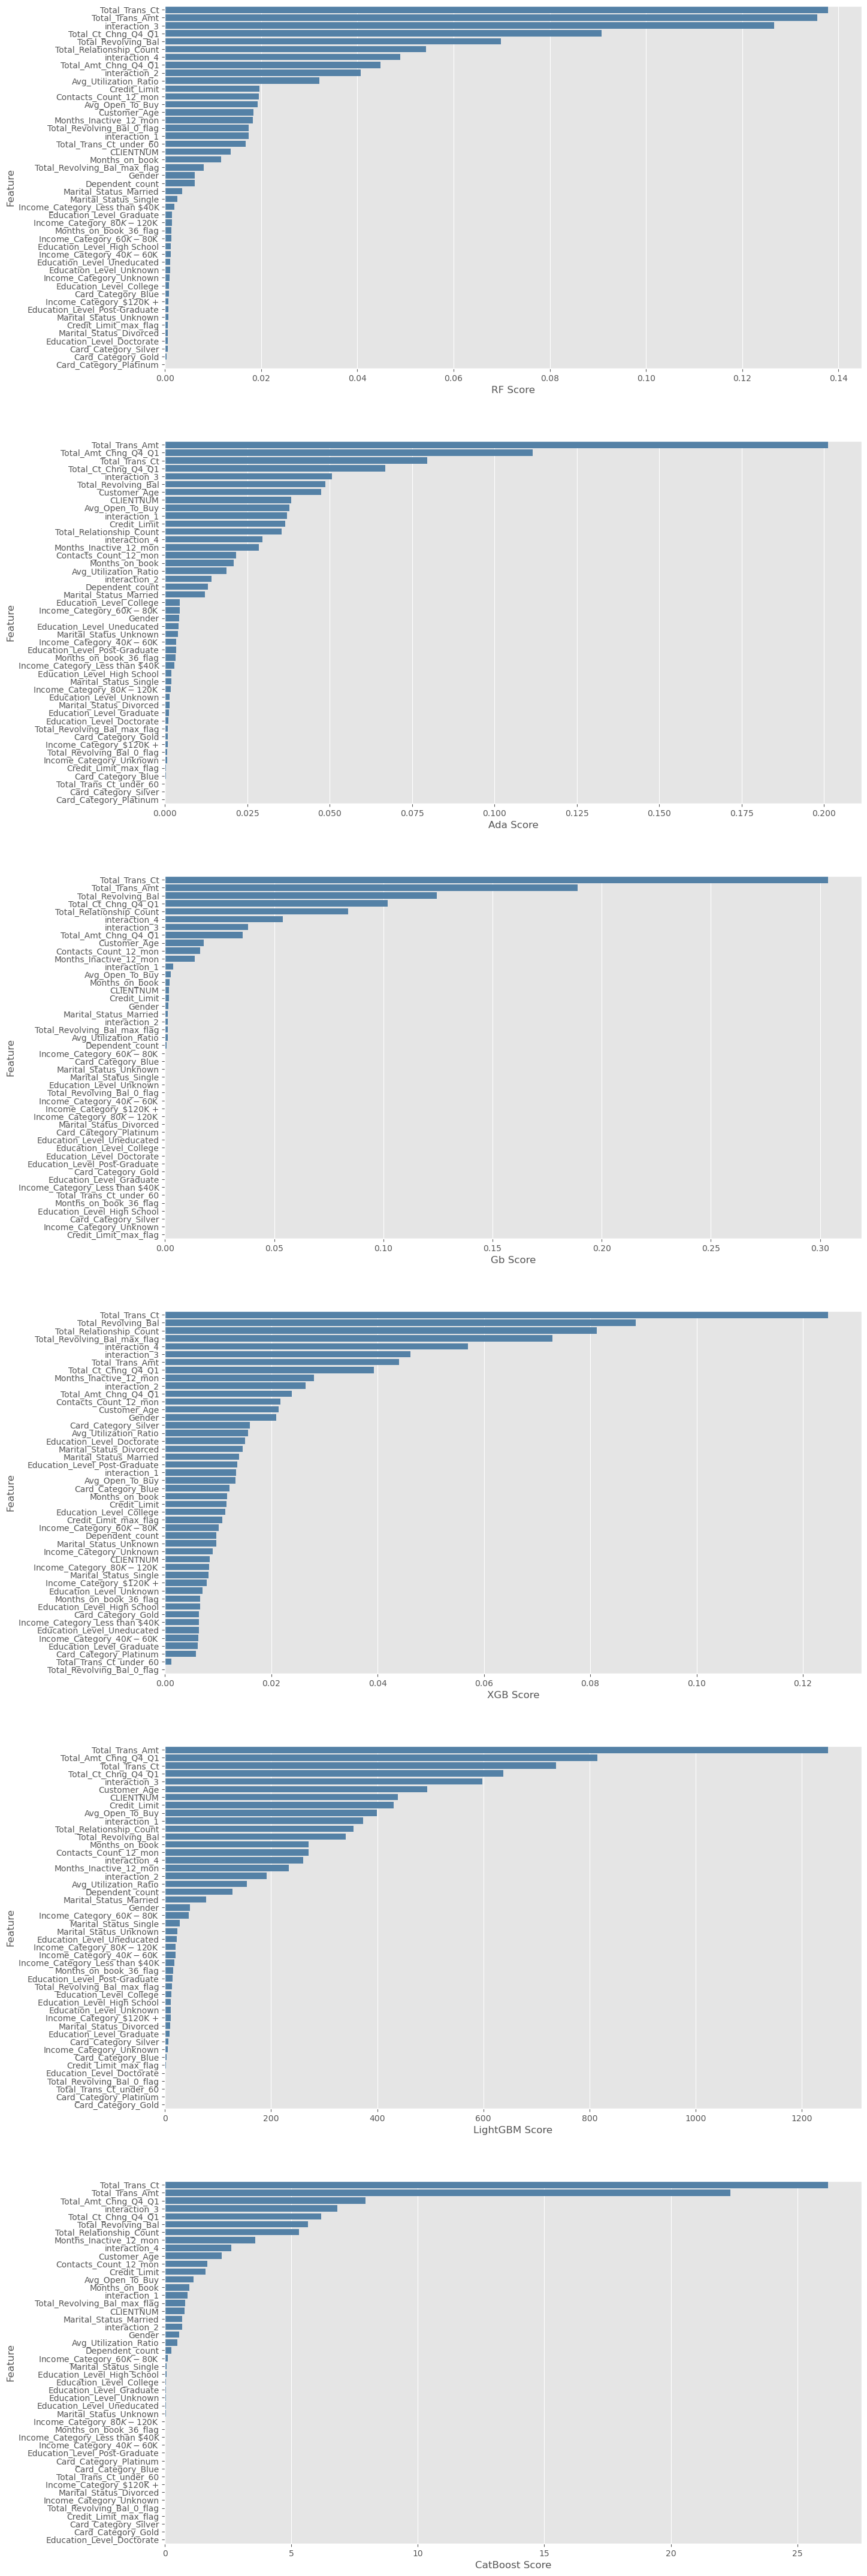

In [21]:
data1 = pd.DataFrame(pd.DataFrame(rf_imp, columns = x.columns).apply(np.mean, axis = 0))
data1['Feature'] = data1.index
data1.columns = ['RF Score', 'Feature']
data1.reset_index(drop = True, inplace = True)
data1.sort_values(by = 'RF Score', ascending = False, inplace = True)

data2 = pd.DataFrame(pd.DataFrame(ada_imp, columns = x.columns).apply(np.mean, axis = 0))
data2['Feature'] = data2.index
data2.columns = ['Ada Score', 'Feature']
data2.reset_index(drop = True, inplace = True)
data2.sort_values(by = 'Ada Score', ascending = False, inplace = True)

data3 = pd.DataFrame(pd.DataFrame(gb_imp, columns = x.columns).apply(np.mean, axis = 0))
data3['Feature'] = data3.index
data3.columns = ['Gb Score', 'Feature']
data3.reset_index(drop = True, inplace = True)
data3.sort_values(by = 'Gb Score', ascending = False, inplace = True)

data4 = pd.DataFrame(pd.DataFrame(xgb_imp, columns = x.columns).apply(np.mean, axis = 0))
data4['Feature'] = data4.index
data4.columns = ['XGB Score', 'Feature']
data4.reset_index(drop = True, inplace = True)
data4.sort_values(by = 'XGB Score', ascending = False, inplace = True)

data5 = pd.DataFrame(pd.DataFrame(lgb_imp, columns = x.columns).apply(np.mean, axis = 0))
data5['Feature'] = data5.index
data5.columns = ['LightGBM Score', 'Feature']
data5.reset_index(drop = True, inplace = True)
data5.sort_values(by = 'LightGBM Score', ascending = False, inplace = True)

data6 = pd.DataFrame(pd.DataFrame(cat_imp, columns = x.columns).apply(np.mean, axis = 0))
data6['Feature'] = data6.index
data6.columns = ['CatBoost Score', 'Feature']
data6.reset_index(drop = True, inplace = True)
data6.sort_values(by = 'CatBoost Score', ascending = False, inplace = True)

fig, axes = plt.subplots(6, 1, figsize = (15, 55))
sns.barplot(ax = axes[0], data = data1, x = 'RF Score', y = 'Feature', color = 'steelblue')
sns.barplot(ax = axes[1], data = data2, x = 'Ada Score', y = 'Feature', color = 'steelblue')
sns.barplot(ax = axes[2], data = data3, x = 'Gb Score', y = 'Feature', color = 'steelblue')
sns.barplot(ax = axes[3], data = data4, x = 'XGB Score', y = 'Feature', color = 'steelblue')
sns.barplot(ax = axes[4], data = data5, x = 'LightGBM Score', y = 'Feature', color = 'steelblue')
sns.barplot(ax = axes[5], data = data6, x = 'CatBoost Score', y = 'Feature', color = 'steelblue');

# Feature Selection

In [22]:
## Defining inputs and target
x = churn.drop(columns = 'Attrition_Flag', axis = 1)
y = churn['Attrition_Flag']

In [23]:
# lists to store supports 
rf_support = list()

for i in range(0,5):
    print(i + 1)
    # splitting the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)
    
    ## Running RFE with Random forest model
    rf_rfecv = RFECV(estimator = RandomForestClassifier(n_estimators = 565, max_depth = 10, min_samples_split = 4, min_samples_leaf = 2), 
                               step = 2, min_features_to_select = 2, cv = 5, scoring = 'f1').fit(x_train, y_train)
    rf_support.append(rf_rfecv.support_)
    clear_output()
    
rf_results = pd.DataFrame(rf_support)
rf_results.columns = x_train.columns

# rf features by percentage of importance
100*rf_results.apply(np.sum, axis = 0) / rf_results.shape[0]

CLIENTNUM                           0.0
Customer_Age                      100.0
Gender                              0.0
Dependent_count                     0.0
Months_on_book                      0.0
Total_Relationship_Count          100.0
Months_Inactive_12_mon             60.0
Contacts_Count_12_mon              60.0
Credit_Limit                       60.0
Total_Revolving_Bal               100.0
Avg_Open_To_Buy                    60.0
Total_Amt_Chng_Q4_Q1              100.0
Total_Trans_Amt                   100.0
Total_Trans_Ct                    100.0
Total_Ct_Chng_Q4_Q1               100.0
Avg_Utilization_Ratio              80.0
Education_Level_College             0.0
Education_Level_Doctorate           0.0
Education_Level_Graduate            0.0
Education_Level_High School         0.0
Education_Level_Post-Graduate       0.0
Education_Level_Uneducated          0.0
Education_Level_Unknown             0.0
Marital_Status_Divorced             0.0
Marital_Status_Married              0.0


In [31]:
# lists to store supports 
ada_support = list()

for i in range(0,5):
    print(i + 1)
    # splitting the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)
    
    ## Running RFE with Ada boost
    ada_rfecv = RFECV(estimator = AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth = 3), learning_rate = 0.05, n_estimators = 843), 
                                step = 2, min_features_to_select = 2, cv = 5, scoring = 'f1').fit(x_train, y_train)
    ada_support.append(ada_rfecv.support_)
    clear_output()
    
ada_results = pd.DataFrame(ada_support)
ada_results.columns = x_train.columns

# ada features by percentage of importance
100*ada_results.apply(np.sum, axis = 0) / ada_results.shape[0]

CLIENTNUM                         100.0
Customer_Age                      100.0
Gender                             60.0
Dependent_count                   100.0
Months_on_book                    100.0
Total_Relationship_Count          100.0
Months_Inactive_12_mon            100.0
Contacts_Count_12_mon             100.0
Credit_Limit                      100.0
Total_Revolving_Bal               100.0
Avg_Open_To_Buy                   100.0
Total_Amt_Chng_Q4_Q1              100.0
Total_Trans_Amt                   100.0
Total_Trans_Ct                    100.0
Total_Ct_Chng_Q4_Q1               100.0
Avg_Utilization_Ratio             100.0
Education_Level_College            60.0
Education_Level_Doctorate          40.0
Education_Level_Graduate           60.0
Education_Level_High School        40.0
Education_Level_Post-Graduate      60.0
Education_Level_Uneducated        100.0
Education_Level_Unknown            60.0
Marital_Status_Divorced            80.0
Marital_Status_Married            100.0


In [30]:
# lists to store supports 
gb_support = list()

for i in range(0,5):
    print(i + 1)
    # splitting the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)
   
    ## Running RFE with Gradient boost
    gb_rfecv = RFECV(estimator = GradientBoostingClassifier(n_estimators = 608, max_depth = 3, min_samples_split = 8, min_samples_leaf = 4, learning_rate = 0.07), 
                                    step = 2, min_features_to_select = 2, cv = 5, scoring = 'f1').fit(x_train, y_train)
    gb_support.append(gb_rfecv.support_)
    clear_output()
    
gb_results = pd.DataFrame(gb_support)
gb_results.columns = x_train.columns

# gb features by percentage of importance
100*gb_results.apply(np.sum, axis = 0) / gb_results.shape[0]

CLIENTNUM                         100.0
Customer_Age                      100.0
Gender                            100.0
Dependent_count                    80.0
Months_on_book                    100.0
Total_Relationship_Count          100.0
Months_Inactive_12_mon            100.0
Contacts_Count_12_mon             100.0
Credit_Limit                      100.0
Total_Revolving_Bal               100.0
Avg_Open_To_Buy                   100.0
Total_Amt_Chng_Q4_Q1              100.0
Total_Trans_Amt                   100.0
Total_Trans_Ct                    100.0
Total_Ct_Chng_Q4_Q1               100.0
Avg_Utilization_Ratio              80.0
Education_Level_College            60.0
Education_Level_Doctorate          60.0
Education_Level_Graduate           20.0
Education_Level_High School        20.0
Education_Level_Post-Graduate      40.0
Education_Level_Uneducated         60.0
Education_Level_Unknown            60.0
Marital_Status_Divorced            80.0
Marital_Status_Married            100.0


In [29]:
# lists to store supports 
xgb_support = list()

for i in range(0,5):
    print(i + 1)
    # splitting the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)

    ## Running RFE with XG boost
    xgb_rfecv = RFECV(estimator = XGBClassifier(learning_rate = 0.05, 
                               n_estimators = 699, 
                               max_depth = 9, 
                               min_child_weight = 1, 
                               gamma = 0.0005483547088903697, 
                               alpha = 0.42287074742618547, 
                               colsample_bytree = 0.7164580608060538, 
                               subsample = 0.725146824073592), 
                               step = 2, min_features_to_select = 2, cv = 5, scoring = 'f1').fit(x_train, y_train)
    xgb_support.append(xgb_rfecv.support_)
    clear_output()

xgb_results = pd.DataFrame(xgb_support)
xgb_results.columns = x_train.columns

# xgb features by percentage of importance
100*xgb_results.apply(np.sum, axis = 0) / xgb_results.shape[0]

CLIENTNUM                          20.0
Customer_Age                      100.0
Gender                            100.0
Dependent_count                    60.0
Months_on_book                     80.0
Total_Relationship_Count          100.0
Months_Inactive_12_mon            100.0
Contacts_Count_12_mon             100.0
Credit_Limit                       80.0
Total_Revolving_Bal               100.0
Avg_Open_To_Buy                    80.0
Total_Amt_Chng_Q4_Q1              100.0
Total_Trans_Amt                   100.0
Total_Trans_Ct                    100.0
Total_Ct_Chng_Q4_Q1               100.0
Avg_Utilization_Ratio             100.0
Education_Level_College            80.0
Education_Level_Doctorate          60.0
Education_Level_Graduate            0.0
Education_Level_High School         0.0
Education_Level_Post-Graduate      80.0
Education_Level_Uneducated          0.0
Education_Level_Unknown             0.0
Marital_Status_Divorced            80.0
Marital_Status_Married            100.0


In [28]:
# lists to store supports 
lgb_support = list()

for i in range(0,5):
    print(i + 1)
    # splitting the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)
    
    ## Running RFE with Light LBM
    lgb_rfecv = RFECV(estimator = LGBMClassifier(n_estimators = 978, 
                                learning_rate = 0.05, 
                                num_leaves = 10, 
                                min_data_in_leaf = 11, 
                                min_child_weight = 0.03965398201870743, 
                                max_depth = 10, 
                                bagging_fraction = 0.5187019106463773, 
                                feature_fraction = 0.5259871906682888, 
                                lambda_l1 = 0.8237522408783435, 
                                lambda_l2 = 0.10755752018607767), 
                                step = 2, min_features_to_select = 2, cv = 5, scoring = 'f1').fit(x_train, y_train)
    lgb_support.append(lgb_rfecv.support_)
    clear_output()

lgb_results = pd.DataFrame(lgb_support)
lgb_results.columns = x_train.columns

# lgb features by percentage of importance
100*lgb_results.apply(np.sum, axis = 0) / lgb_results.shape[0]

CLIENTNUM                         100.0
Customer_Age                      100.0
Gender                             80.0
Dependent_count                   100.0
Months_on_book                    100.0
Total_Relationship_Count          100.0
Months_Inactive_12_mon            100.0
Contacts_Count_12_mon             100.0
Credit_Limit                      100.0
Total_Revolving_Bal               100.0
Avg_Open_To_Buy                   100.0
Total_Amt_Chng_Q4_Q1              100.0
Total_Trans_Amt                   100.0
Total_Trans_Ct                    100.0
Total_Ct_Chng_Q4_Q1               100.0
Avg_Utilization_Ratio             100.0
Education_Level_College            40.0
Education_Level_Doctorate          20.0
Education_Level_Graduate           40.0
Education_Level_High School        40.0
Education_Level_Post-Graduate      60.0
Education_Level_Uneducated         60.0
Education_Level_Unknown            40.0
Marital_Status_Divorced            20.0
Marital_Status_Married            100.0


In [27]:
# lists to store supports 
cat_support = list()

for i in range(0,5):
    print(i + 1)
    # splitting the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)
    
    ## Running RFE with Cat boost
    cat_rfecv = RFECV(estimator = CatBoostClassifier(iterations = 718, 
                                    learning_rate = 0.05, 
                                    min_data_in_leaf = 83, 
                                    depth = 7, 
                                    random_strength = 0.37417111608782183, 
                                    bagging_temperature = 0.9787134832707909, 
                                    border_count = 85, 
                                    l2_leaf_reg = 58, 
                                    verbose = False), 
                                    step = 2, min_features_to_select = 2, cv = 5, scoring = 'f1').fit(x_train, y_train)
    cat_support.append(cat_rfecv.support_)
    clear_output()

cat_results = pd.DataFrame(cat_support)
cat_results.columns = x_train.columns

# lgb features by percentage of importance
100*cat_results.apply(np.sum, axis = 0) / cat_results.shape[0]

CLIENTNUM                         100.0
Customer_Age                      100.0
Gender                             80.0
Dependent_count                    60.0
Months_on_book                    100.0
Total_Relationship_Count          100.0
Months_Inactive_12_mon            100.0
Contacts_Count_12_mon             100.0
Credit_Limit                      100.0
Total_Revolving_Bal               100.0
Avg_Open_To_Buy                   100.0
Total_Amt_Chng_Q4_Q1              100.0
Total_Trans_Amt                   100.0
Total_Trans_Ct                    100.0
Total_Ct_Chng_Q4_Q1               100.0
Avg_Utilization_Ratio              80.0
Education_Level_College             0.0
Education_Level_Doctorate          40.0
Education_Level_Graduate           20.0
Education_Level_High School        40.0
Education_Level_Post-Graduate      20.0
Education_Level_Uneducated         40.0
Education_Level_Unknown            20.0
Marital_Status_Divorced            20.0
Marital_Status_Married             80.0


In [32]:
# combining results
(100*rf_results.apply(np.sum, axis = 0) / 30) + (100*ada_results.apply(np.sum, axis = 0) / 30) + (100*gb_results.apply(np.sum, axis = 0) / 30) + (100*xgb_results.apply(np.sum, axis = 0) / 30) + (100*lgb_results.apply(np.sum, axis = 0) / 30) + (100*cat_results.apply(np.sum, axis = 0) / 30)

CLIENTNUM                          70.000000
Customer_Age                      100.000000
Gender                             70.000000
Dependent_count                    66.666667
Months_on_book                     80.000000
Total_Relationship_Count          100.000000
Months_Inactive_12_mon             93.333333
Contacts_Count_12_mon              93.333333
Credit_Limit                       90.000000
Total_Revolving_Bal               100.000000
Avg_Open_To_Buy                    90.000000
Total_Amt_Chng_Q4_Q1              100.000000
Total_Trans_Amt                   100.000000
Total_Trans_Ct                    100.000000
Total_Ct_Chng_Q4_Q1               100.000000
Avg_Utilization_Ratio              90.000000
Education_Level_College            40.000000
Education_Level_Doctorate          36.666667
Education_Level_Graduate           23.333333
Education_Level_High School        23.333333
Education_Level_Post-Graduate      43.333333
Education_Level_Uneducated         43.333333
Education_

# Hyper-parameter optimization

In [40]:
def objective(trial):
    
    # defining search space
    params = dict(n_estimators = trial.suggest_int('n_estimators', 100, 1000),
                    max_depth = trial.suggest_int('max_depth', 2, 10),
                    min_samples_split = trial.suggest_int('min_samples_split', 3, 10),
                    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10))
    
    # definging model
    model = RandomForestClassifier(**params)
                  
    avg_f1 = []

    # Definition of k-fold cross validation
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

    for train_ix, test_ix in skf.split(x, y):

        ## Splitting the data 
        x_train, x_test = x.iloc[train_ix], x.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

        # Training
        model.fit(x_train, y_train)

        ## Predicting on X_test
        model_pred = model.predict_proba(x_test)[:, 1]
        ## changing likilyhoods to labels
        model_label = precision_recall_cutoff(y_test, model_pred)

        # Save roc
        avg_f1.append(f1_score(y_test, model_label))

    return np.mean(avg_f1)

## Defining inputs and target for rf
x = churn[['Customer_Age', 'Total_Relationship_Count', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'interaction_1', 'interaction_2',
           'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'interaction_3', 'interaction_4', 'Avg_Utilization_Ratio']]
y = churn['Attrition_Flag']

study = optuna.create_study(direction='maximize')
# Opimization
# Recevies the function to be optimized and the number of trials
study.optimize(objective, n_trials = 50)
clear_output()
print('Best trial: ', study.best_trial.params)
print('Best value: ', study.best_value)

Best trial:  {'n_estimators': 974, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2}
Best value:  0.8879034867529333


In [41]:
def objective(trial):
    
    # defining search space
    learning_rate = trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.05, 0.08, 0.1])
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    
    # definging model
    model = AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth = max_depth),n_estimators = n_estimators, learning_rate = learning_rate)
                  
    avg_f1 = []

    # Definition of k-fold cross validation
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

    for train_ix, test_ix in skf.split(x, y):

        ## Splitting the data 
        x_train, x_test = x.iloc[train_ix], x.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

        # Training
        model.fit(x_train, y_train)

        ## Predicting on X_test
        model_pred = model.predict_proba(x_test)[:, 1]
        ## changing likilyhoods to labels
        model_label = precision_recall_cutoff(y_test, model_pred)

        # Save roc
        avg_f1.append(f1_score(y_test, model_label))

    return np.mean(avg_f1)

## Defining inputs and target for ada
x = churn[['CLIENTNUM', 'Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 
           'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'interaction_1', 'interaction_2',
           'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Marital_Status_Married', 'interaction_3', 'interaction_4', 'Avg_Utilization_Ratio']]
y = churn['Attrition_Flag']

study = optuna.create_study(direction='maximize')
# Opimization
# Recevies the function to be optimized and the number of trials
study.optimize(objective, n_trials = 50)
clear_output()
print('Best trial: ', study.best_trial.params)
print('Best value: ', study.best_value)

Best trial:  {'learning_rate': 0.08, 'n_estimators': 438, 'max_depth': 3}
Best value:  0.9203240006957465


In [42]:
def objective(trial):
    
    # defining search space
    params = dict(n_estimators = trial.suggest_int('n_estimators', 100, 1000),
                     max_depth = trial.suggest_int('max_depth', 2, 10),
                     min_samples_split = trial.suggest_int('min_samples_split', 3, 10),
                     min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10),
                     learning_rate = trial.suggest_float('learning_rate', 0.01, .1))
    
    # definging model
    model = GradientBoostingClassifier(**params)
                  
    avg_f1 = []

    # Definition of k-fold cross validation
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

    for train_ix, test_ix in skf.split(x, y):

        ## Splitting the data 
        x_train, x_test = x.iloc[train_ix], x.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

        # Training
        model.fit(x_train, y_train)

        ## Predicting on X_test
        model_pred = model.predict_proba(x_test)[:, 1]
        ## changing likilyhoods to labels
        model_label = precision_recall_cutoff(y_test, model_pred)

        # Save roc
        avg_f1.append(f1_score(y_test, model_label))

    return np.mean(avg_f1)

## Defining inputs and target for gb
x = churn[['CLIENTNUM', 'Customer_Age', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Revolving_Bal',
           'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'interaction_1','Total_Ct_Chng_Q4_Q1', 'interaction_3', 'interaction_4']]
y = churn['Attrition_Flag']  

study = optuna.create_study(direction='maximize')
# Opimization
# Recevies the function to be optimized and the number of trials
study.optimize(objective, n_trials = 50)
clear_output()
print('Best trial: ', study.best_trial.params)
print('Best value: ', study.best_value)

Best trial:  {'n_estimators': 958, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 6, 'learning_rate': 0.05471905209525808}
Best value:  0.9186954641704219


In [43]:
def objective(trial):
    
    # defining search space
    params = dict(max_iter = trial.suggest_int('max_iter', 100, 1000),
                    learning_rate = trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.05, 0.08, 0.1]),
                    l2_regularization = trial.suggest_categorical('l2_regularization', [0.005, 0.02, 0.05, 0.08, 0.1]),
                    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 200),
                    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 200),
                    max_depth = trial.suggest_int('max_depth', 1, 10),
                    max_bins = trial.suggest_int('max_bins', 2, 255))
    
    # definging model
    model = HistGradientBoostingClassifier(**params)
                  
    avg_f1 = []

    # Definition of k-fold cross validation
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

    for train_ix, test_ix in skf.split(x, y):

        ## Splitting the data 
        x_train, x_test = x.iloc[train_ix], x.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

        # Training
        model.fit(x_train, y_train)

        ## Predicting on X_test
        model_pred = model.predict_proba(x_test)[:, 1]
        ## changing likilyhoods to labels
        model_label = precision_recall_cutoff(y_test, model_pred)

        # Save roc
        avg_f1.append(f1_score(y_test, model_label))

    return np.mean(avg_f1)

## Defining inputs and target for hgb
x = churn[['Customer_Age', 'Total_Relationship_Count', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'interaction_1', 'interaction_2',
           'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'interaction_3', 'interaction_4', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Avg_Utilization_Ratio']]
y = churn['Attrition_Flag']

study = optuna.create_study(direction='maximize')
# Opimization
# Recevies the function to be optimized and the number of trials
study.optimize(objective, n_trials = 50)
clear_output()
print('Best trial: ', study.best_trial.params)
print('Best value: ', study.best_value)

Best trial:  {'max_iter': 520, 'learning_rate': 0.1, 'l2_regularization': 0.1, 'min_samples_leaf': 7, 'max_leaf_nodes': 103, 'max_depth': 3, 'max_bins': 205}
Best value:  0.9171346737471933


In [39]:
def objective(trial):
    
    # defining search space
    params = dict(learning_rate = trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.05, 0.08, 0.1]),
                    n_estimators = trial.suggest_int('n_estimators', 100, 1000),
                    max_depth = trial.suggest_int('max_depth', 2, 10),
                    min_child_weight = trial.suggest_int('min_child_weight', 1, 300),
                    gamma = trial.suggest_float('gamma', 0.0001, 1.0, log = True),
                    alpha = trial.suggest_float('alpha', 0.0001, 10.0, log = True),
                    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 0.8),
                    subsample = trial.suggest_float('subsample', 0.1, 0.8))
    
    # definging model
    model = XGBClassifier(**params)
                  
    avg_f1 = []

    # Definition of k-fold cross validation
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

    for train_ix, test_ix in skf.split(x, y):

        ## Splitting the data 
        x_train, x_test = x.iloc[train_ix], x.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

        # Training
        model.fit(x_train, y_train)

        ## Predicting on X_test
        model_pred = model.predict_proba(x_test)[:, 1]
        ## changing likilyhoods to labels
        model_label = precision_recall_cutoff(y_test, model_pred)

        # Save roc
        avg_f1.append(f1_score(y_test, model_label))

    return np.mean(avg_f1)

## Defining inputs and target for xgb
x = churn[['Customer_Age', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
           'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Marital_Status_Married', 'interaction_3', 'interaction_4', 'Total_Revolving_Bal_max_flag']]
y = churn['Attrition_Flag']

study = optuna.create_study(direction='maximize')
# Opimization
# Recevies the function to be optimized and the number of trials
study.optimize(objective, n_trials = 50)
clear_output()
print('Best trial: ', study.best_trial.params)
print('Best value: ', study.best_value)

Best trial:  {'learning_rate': 0.02, 'n_estimators': 622, 'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.0030115414389802427, 'alpha': 3.3054988531680833, 'colsample_bytree': 0.5111153062068741, 'subsample': 0.4337419128945546}
Best value:  0.9118357146902045


In [44]:
def objective(trial):
    
    # defining search space
    params = dict(n_estimators = trial.suggest_int('n_estimators', 100, 1000),
                    learning_rate = trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.05, 0.08, 0.1]),
                    num_leaves = trial.suggest_int('num_leaves', 10, 1000),
                    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 10, 200),
                    min_child_weight = trial.suggest_float('min_child_weight', 0.001, 0.1),
                    max_depth = trial.suggest_int('max_depth', 1, 10),
                    bagging_fraction = trial.suggest_float('bagging_fraction', .5, .99),
                    feature_fraction = trial.suggest_float('feature_fraction', .5, .99),
                    lambda_l1 = trial.suggest_float('lambda_l1', 0.1, 2),
                    lambda_l2 = trial.suggest_float('lambda_l2', 0.1, 2))
    
    # definging model
    model = LGBMClassifier(**params)
                  
    avg_f1 = []

    # Definition of k-fold cross validation
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

    for train_ix, test_ix in skf.split(x, y):

        ## Splitting the data 
        x_train, x_test = x.iloc[train_ix], x.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

        # Training
        model.fit(x_train, y_train)

        ## Predicting on X_test
        model_pred = model.predict_proba(x_test)[:, 1]
        ## changing likilyhoods to labels
        model_label = precision_recall_cutoff(y_test, model_pred)

        # Save roc
        avg_f1.append(f1_score(y_test, model_label))

    return np.mean(avg_f1)

## Defining inputs and target for lgb
x = churn[['CLIENTNUM', 'Customer_Age', 'Gender', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit',
           'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Marital_Status_Married', 
           'Income_Category_$60K - $80K', 'interaction_1', 'interaction_2', 'interaction_3', 'interaction_4']]
y = churn['Attrition_Flag']

study = optuna.create_study(direction='maximize')
# Opimization
# Recevies the function to be optimized and the number of trials
study.optimize(objective, n_trials = 50)
clear_output()
print('Best trial: ', study.best_trial.params)
print('Best value: ', study.best_value)

Best trial:  {'n_estimators': 966, 'learning_rate': 0.02, 'num_leaves': 313, 'min_data_in_leaf': 37, 'min_child_weight': 0.07766688980407589, 'max_depth': 9, 'bagging_fraction': 0.6568954564667657, 'feature_fraction': 0.5244625947440009, 'lambda_l1': 0.931602725061808, 'lambda_l2': 1.091601491941248}
Best value:  0.9215893408927854


In [45]:
def objective(trial):
    
    # defining search space
    params = dict(iterations = trial.suggest_int('iterations', 100, 1000),
                    learning_rate = trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.05, 0.08, 0.1]),
                    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 10, 200),
                    depth = trial.suggest_int('depth', 1, 10),
                    random_strength = trial.suggest_float('random_strength', 0, 1), 
                    bagging_temperature = trial.suggest_float('bagging_temperature', 0, 1),
                    border_count = trial.suggest_int('border_count', 1, 100),
                    l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 1, 100),
                    verbose = trial.suggest_categorical('verbose', [False]))
    
    # definging model
    model = CatBoostClassifier(**params)
                  
    avg_f1 = []

    # Definition of k-fold cross validation
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

    for train_ix, test_ix in skf.split(x, y):

        ## Splitting the data 
        x_train, x_test = x.iloc[train_ix], x.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

        # Training
        model.fit(x_train, y_train)

        ## Predicting on X_test
        model_pred = model.predict_proba(x_test)[:, 1]
        ## changing likilyhoods to labels
        model_label = precision_recall_cutoff(y_test, model_pred)

        # Save roc
        avg_f1.append(f1_score(y_test, model_label))

    return np.mean(avg_f1)

## Defining inputs and target for cat
x = churn[['CLIENTNUM', 'Customer_Age', 'Gender', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit',
           'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Marital_Status_Married', 
           'Marital_Status_Single', 'Marital_Status_Unknown', 'Income_Category_$60K - $80K', 'interaction_1', 'interaction_2', 'interaction_3', 'interaction_4', 'Total_Revolving_Bal_max_flag']]
y = churn['Attrition_Flag']

study = optuna.create_study(direction='maximize')
# Opimization
# Recevies the function to be optimized and the number of trials
study.optimize(objective, n_trials = 50)
clear_output()
print('Best trial: ', study.best_trial.params)
print('Best value: ', study.best_value)

Best trial:  {'iterations': 699, 'learning_rate': 0.1, 'min_data_in_leaf': 154, 'depth': 7, 'random_strength': 0.7672319235779396, 'bagging_temperature': 0.34078698773221083, 'border_count': 79, 'l2_leaf_reg': 64, 'verbose': False}
Best value:  0.9265142096868841


# Final Models and Ensemles

In [19]:
## Defining inputs and target
# these are all the variables that showed up at least 90% of the time through all models
x = churn[['Customer_Age', 'Total_Relationship_Count', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'interaction_1', 'interaction_2',
           'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'interaction_3', 'interaction_4', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Avg_Utilization_Ratio']]
y = churn['Attrition_Flag']

In [47]:
rf_accuracy, ada_accuracy, gb_accuracy, hgb_accuracy, xgb_accuracy, lgb_accuracy, cat_accuracy = list(), list(), list(), list(), list(), list(), list()
rf_accuracy_scores, ada_accuracy_scores, gb_accuracy_scores, hgb_accuracy_scores, xgb_accuracy_scores, lgb_accuracy_scores, cat_accuracy_scores = list(), list(), list(), list(), list(), list(), list()
rf_cv_score, ada_cv_score, gb_cv_score, hgb_cv_score, xgb_cv_score, lgb_cv_score, cat_cv_score = list(), list(), list(), list(), list(), list(), list()

## Running 5 times CV
for i in range(5):
    print(i)
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(x, y):
        
        ## Splitting the data 
        x_train, x_test = x.iloc[train_ix], x.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    
        ## Building RF model ##
        rf_md = RandomForestClassifier(n_estimators = 974, max_depth = 10, min_samples_split = 5, min_samples_leaf = 2).fit(x_train, y_train)
        ## Predicting on X_test and test
        rf_pred = rf_md.predict_proba(x_test)[:, 1]
        ## changing likilyhoods to labels
        rf_label = precision_recall_cutoff(y_test, rf_pred)
        
        ## Building RF model ##
        ada_md = AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth = 3), learning_rate = 0.08, n_estimators = 438).fit(x_train, y_train)
        ## Predicting on X_test and test
        ada_pred = ada_md.predict_proba(x_test)[:, 1]
        ## changing likilyhoods to labels
        ada_label = precision_recall_cutoff(y_test, ada_pred)
        
        ## Building gb model ##
        gb_md = GradientBoostingClassifier(n_estimators = 958, max_depth = 3, min_samples_split = 8, min_samples_leaf = 6, learning_rate = 0.05471905209525808).fit(x_train, y_train)
        ## Predicting on X_test and test
        gb_pred = gb_md.predict_proba(x_test)[:, 1]
        ## changing likilyhoods to labels
        gb_label = precision_recall_cutoff(y_test, gb_pred)
        
        ## Building hgb model ##
        hgb_md = HistGradientBoostingClassifier(max_iter = 520, 
                                                learning_rate = 0.1, 
                                                l2_regularization = 0.1, min_samples_leaf = 7, 
                                                max_leaf_nodes = 103, 
                                                max_depth = 3, 
                                                max_bins = 205).fit(x_train, y_train)
        ## Predicting on X_test and test
        hgb_pred = hgb_md.predict_proba(x_test)[:, 1]
        ## changing likilyhoods to labels
        hgb_label = precision_recall_cutoff(y_test, hgb_pred)
        
        ## Building xgb model ##
        xgb_md = XGBClassifier(learning_rate = 0.02, 
                               n_estimators = 622, 
                               max_depth = 6, 
                               min_child_weight = 1, 
                               gamma = 0.0030115414389802427, 
                               alpha = 3.3054988531680833, 
                               colsample_bytree = 0.5111153062068741, 
                               subsample = 0.4337419128945546).fit(x_train, y_train)
        ## Predicting on X_test and test
        xgb_pred = xgb_md.predict_proba(x_test)[:, 1]
        ## changing likilyhoods to labels
        xgb_label = precision_recall_cutoff(y_test, xgb_pred)
        
        ## Building lgb model ##
        lgb_md = LGBMClassifier(n_estimators = 966, 
                                learning_rate = 0.02, 
                                num_leaves = 313, 
                                min_data_in_leaf = 37, 
                                min_child_weight = 0.07766688980407589, 
                                max_depth = 9, 
                                bagging_fraction = 0.6568954564667657, 
                                feature_fraction = 0.5244625947440009, 
                                lambda_l1 = 0.931602725061808, 
                                lambda_l2 = 1.091601491941248).fit(x_train, y_train)
        ## Predicting on X_test and test
        lgb_pred = lgb_md.predict_proba(x_test)[:, 1]
        ## changing likilyhoods to labels
        lgb_label = precision_recall_cutoff(y_test, lgb_pred)
        clear_output()
        
        ## Building cat model ##
        cat_md = CatBoostClassifier(iterations = 699, 
                                    learning_rate = 0.1, 
                                    min_data_in_leaf = 154, 
                                    depth = 7, 
                                    random_strength = 0.7672319235779396, 
                                    bagging_temperature = 0.34078698773221083, 
                                    border_count = 79, 
                                    l2_leaf_reg = 64, 
                                    verbose = False).fit(x_train, y_train)
        ## Predicting on X_test and test
        cat_pred = cat_md.predict_proba(x_test)[:, 1]
        ## changing likilyhoods to labels
        cat_label = precision_recall_cutoff(y_test, cat_pred)
        
        ## Computing metrics
        rf_accuracy.append(accuracy_score(rf_label, y_test))
        ada_accuracy.append(accuracy_score(ada_label, y_test))
        gb_accuracy.append(accuracy_score(gb_label, y_test))
        hgb_accuracy.append(accuracy_score(hgb_label, y_test))
        xgb_accuracy.append(accuracy_score(xgb_label, y_test))
        lgb_accuracy.append(accuracy_score(lgb_label, y_test))
        cat_accuracy.append(accuracy_score(cat_label, y_test))
        
    rf_accuracy_scores.append(np.mean(rf_accuracy))
    ada_accuracy_scores.append(np.mean(ada_accuracy))
    gb_accuracy_scores.append(np.mean(gb_accuracy))
    hgb_accuracy_scores.append(np.mean(hgb_accuracy))
    xgb_accuracy_scores.append(np.mean(xgb_accuracy))
    lgb_accuracy_scores.append(np.mean(lgb_accuracy))
    cat_accuracy_scores.append(np.mean(cat_accuracy))

rf_cv_score = np.mean(rf_accuracy_scores)
ada_cv_score = np.mean(ada_accuracy_scores)
gb_cv_score = np.mean(gb_accuracy_scores)
hgb_cv_score = np.mean(hgb_accuracy_scores)
xgb_cv_score = np.mean(xgb_accuracy_scores)
lgb_cv_score = np.mean(lgb_accuracy_scores)
cat_cv_score = np.mean(cat_accuracy_scores)

print('The accuracy score of the rf model over 5-folds (run 5 times) is:', rf_cv_score)
print('The accuracy score of the ada model over 5-folds (run 5 times) is:', ada_cv_score)
print('The accuracy score of the gb model over 5-folds (run 5 times) is:', gb_cv_score)
print('The accuracy score of the hgb model over 5-folds (run 5 times) is:', hgb_cv_score)
print('The accuracy score of the xgb model over 5-folds (run 5 times) is:', xgb_cv_score)
print('The accuracy score of the lgb model over 5-folds (run 5 times) is:', lgb_cv_score)
print('The accuracy score of the cat model over 5-folds (run 5 times) is:', cat_cv_score)

The accuracy score of the rf model over 5-folds (run 5 times) is: 0.9633859559065483
The accuracy score of the ada model over 5-folds (run 5 times) is: 0.9730424481737414
The accuracy score of the gb model over 5-folds (run 5 times) is: 0.9736346995234788
The accuracy score of the hgb model over 5-folds (run 5 times) is: 0.974819884708664
The accuracy score of the xgb model over 5-folds (run 5 times) is: 0.9715610641902185
The accuracy score of the lgb model over 5-folds (run 5 times) is: 0.9739311908156922
The accuracy score of the cat model over 5-folds (run 5 times) is: 0.976399790379389


In [48]:
model_preds = pd.DataFrame({'gb preds': gb_label, 'hgb preds': hgb_label, 'xgb preds': xgb_label, 'lgb preds': lgb_label, 'cat preds': cat_label})
model_preds['vote'] = model_preds.mode(axis = 1)
model_preds

,gb preds,hgb preds,xgb preds,lgb preds,cat preds,vote
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
2020,0,0,0,0,0,0
2021,1,1,1,1,1,1
2022,0,0,0,0,0,0
2023,1,1,1,1,1,1


In [49]:
print(accuracy_score(model_preds['vote'], y_test))
print(recall_score(model_preds['vote'], y_test))

0.9797530864197531
0.9303030303030303


In [50]:
rf_accuracy, ada_accuracy, gb_accuracy, hgb_accuracy, xgb_accuracy, lgb_accuracy, cat_accuracy = list(), list(), list(), list(), list(), list(), list()
rf_accuracy_scores, ada_accuracy_scores, gb_accuracy_scores, hgb_accuracy_scores, xgb_accuracy_scores, lgb_accuracy_scores, cat_accuracy_scores = list(), list(), list(), list(), list(), list(), list()
rf_cv_score, ada_cv_score, gb_cv_score, hgb_cv_score, xgb_cv_score, lgb_cv_score, cat_cv_score = list(), list(), list(), list(), list(), list(), list()

## Defining inputs and target for rf
x = churn[['Customer_Age', 'Total_Relationship_Count', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'interaction_1', 'interaction_2',
           'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'interaction_3', 'interaction_4', 'Avg_Utilization_Ratio']]
y = churn['Attrition_Flag']
## Running 5 times CV for each model
for i in range(5):
    print('rf: ', i)
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(x, y):
        
        ## Splitting the data 
        x_train, x_test = x.iloc[train_ix], x.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    
        ## Building RF model ##
        rf_md = RandomForestClassifier(n_estimators = 974, max_depth = 10, min_samples_split = 5, min_samples_leaf = 2).fit(x_train, y_train)
        ## Predicting on X_test and test
        rf_pred = rf_md.predict_proba(x_test)[:, 1]
        ## changing likilyhoods to labels
        rf_label = precision_recall_cutoff(y_test, rf_pred)
        ## computing metrics
        rf_accuracy.append(accuracy_score(rf_label, y_test))
        
    rf_accuracy_scores.append(np.mean(rf_accuracy))
    clear_output()

## Defining inputs and target for ada
x = churn[['CLIENTNUM', 'Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 
           'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'interaction_1', 'interaction_2',
           'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Marital_Status_Married', 'interaction_3', 'interaction_4', 'Avg_Utilization_Ratio']]
y = churn['Attrition_Flag']

for i in range(5):
    print('ada: ', i)
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(x, y):
        
        ## Splitting the data 
        x_train, x_test = x.iloc[train_ix], x.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
        ## Building RF model ##
        ada_md = AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth = 3), learning_rate = 0.08, n_estimators = 438).fit(x_train, y_train)
        ## Predicting on X_test and test
        ada_pred = ada_md.predict_proba(x_test)[:, 1]
        ## changing likilyhoods to labels
        ada_label = precision_recall_cutoff(y_test, ada_pred)
        ## computing metrics
        ada_accuracy.append(accuracy_score(ada_label, y_test))
        
    ada_accuracy_scores.append(np.mean(ada_accuracy))
    clear_output()

## Defining inputs and target for gb
x = churn[['CLIENTNUM', 'Customer_Age', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Revolving_Bal',
           'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'interaction_1','Total_Ct_Chng_Q4_Q1', 'interaction_3', 'interaction_4']]
y = churn['Attrition_Flag']    

for i in range(5):
    print('gb: ', i)
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(x, y):
        
        ## Splitting the data 
        x_train, x_test = x.iloc[train_ix], x.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]        
        
        ## Building gb model ##
        gb_md = GradientBoostingClassifier(n_estimators = 958, max_depth = 3, min_samples_split = 8, min_samples_leaf = 6, learning_rate = 0.05471905209525808).fit(x_train, y_train)
        ## Predicting on X_test and test
        gb_pred = gb_md.predict_proba(x_test)[:, 1]
        ## changing likilyhoods to labels
        gb_label = precision_recall_cutoff(y_test, gb_pred)
        ## computing metrics
        gb_accuracy.append(accuracy_score(gb_label, y_test))
        
    gb_accuracy_scores.append(np.mean(gb_accuracy))
    clear_output()

## Defining inputs and target for hgb
x = churn[['Customer_Age', 'Total_Relationship_Count', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'interaction_1', 'interaction_2',
           'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'interaction_3', 'interaction_4', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Avg_Utilization_Ratio']]
y = churn['Attrition_Flag']

for i in range(5):
    print('hgb', i)
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(x, y):
        
        ## Splitting the data 
        x_train, x_test = x.iloc[train_ix], x.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]        
        
        ## Building hgb model ##
        hgb_md = HistGradientBoostingClassifier(max_iter = 520, 
                                                learning_rate = 0.1, 
                                                l2_regularization = 0.1, 
                                                min_samples_leaf = 7, 
                                                max_leaf_nodes = 103, 
                                                max_depth = 3, 
                                                max_bins = 205).fit(x_train, y_train)
        ## Predicting on X_test and test
        hgb_pred = hgb_md.predict_proba(x_test)[:, 1]
        ## changing likilyhoods to labels
        hgb_label = precision_recall_cutoff(y_test, hgb_pred)
        ## computing metrics
        hgb_accuracy.append(accuracy_score(hgb_label, y_test))
    
    hgb_accuracy_scores.append(np.mean(hgb_accuracy))
    clear_output()
    
## Defining inputs and target for xgb
x = churn[['Customer_Age', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
           'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Marital_Status_Married', 'interaction_3', 'interaction_4', 'Total_Revolving_Bal_max_flag']]
y = churn['Attrition_Flag']
        
for i in range(5):
    print('xgb: ', i)
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(x, y):
        
        ## Splitting the data 
        x_train, x_test = x.iloc[train_ix], x.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]        
        
        ## Building xgb model ##
        xgb_md = XGBClassifier(learning_rate = 0.02, 
                               n_estimators = 622, 
                               max_depth = 6, 
                               min_child_weight = 1, 
                               gamma = 0.0030115414389802427, 
                               alpha = 3.3054988531680833, 
                               colsample_bytree = 0.5111153062068741, 
                               subsample = 0.4337419128945546).fit(x_train, y_train)
        ## Predicting on X_test and test
        xgb_pred = xgb_md.predict_proba(x_test)[:, 1]
        ## changing likilyhoods to labels
        xgb_label = precision_recall_cutoff(y_test, xgb_pred)
        ## computing metrics
        xgb_accuracy.append(accuracy_score(xgb_label, y_test))
        
    xgb_accuracy_scores.append(np.mean(xgb_accuracy))
    clear_output()
        
## Defining inputs and target for lgb
x = churn[['CLIENTNUM', 'Customer_Age', 'Gender', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit',
           'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Marital_Status_Married', 
           'Income_Category_$60K - $80K', 'interaction_1', 'interaction_2', 'interaction_3', 'interaction_4']]
y = churn['Attrition_Flag']
        
for i in range(5):
    print('lgb: ', i)
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(x, y):
        
        ## Splitting the data 
        x_train, x_test = x.iloc[train_ix], x.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]        
        
        ## Building lgb model ##
        lgb_md = LGBMClassifier(n_estimators = 966, 
                                learning_rate = 0.02, 
                                num_leaves = 313, 
                                min_data_in_leaf = 37, 
                                min_child_weight = 0.07766688980407589, 
                                max_depth = 9, 
                                bagging_fraction = 0.6568954564667657, 
                                feature_fraction = 0.5244625947440009, 
                                lambda_l1 = 0.931602725061808, 
                                lambda_l2 = 1.091601491941248).fit(x_train, y_train)
        ## Predicting on X_test and test
        lgb_pred = lgb_md.predict_proba(x_test)[:, 1]
        ## changing likilyhoods to labels
        lgb_label = precision_recall_cutoff(y_test, lgb_pred)
        ## computing metrics                               
        lgb_accuracy.append(accuracy_score(lgb_label, y_test))
        
    lgb_accuracy_scores.append(np.mean(lgb_accuracy))
    clear_output()
    
## Defining inputs and target for cat
x = churn[['CLIENTNUM', 'Customer_Age', 'Gender', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit',
           'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Marital_Status_Married', 
           'Marital_Status_Single', 'Marital_Status_Unknown', 'Income_Category_$60K - $80K', 'interaction_1', 'interaction_2', 'interaction_3', 'interaction_4', 'Total_Revolving_Bal_max_flag']]
y = churn['Attrition_Flag']
        
for i in range(5):
    print('cat: ', i)
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(x, y):
        
        ## Splitting the data 
        x_train, x_test = x.iloc[train_ix], x.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]        
        
        ## Building cat model ##
        cat_md = CatBoostClassifier(iterations = 699, 
                                    learning_rate = 0.1, 
                                    min_data_in_leaf = 154, 
                                    depth = 7, 
                                    random_strength = 0.7672319235779396, 
                                    bagging_temperature = 0.34078698773221083, 
                                    border_count = 79, 
                                    l2_leaf_reg = 64, 
                                    verbose = False).fit(x_train, y_train)
        ## Predicting on X_test and test
        cat_pred = cat_md.predict_proba(x_test)[:, 1]
        ## changing likilyhoods to labels
        cat_label = precision_recall_cutoff(y_test, cat_pred)
        ## computing metrics
        ## Computing metrics
        cat_accuracy.append(accuracy_score(cat_label, y_test))
        
    cat_accuracy_scores.append(np.mean(cat_accuracy))
    clear_output()
    
rf_cv_score = np.mean(rf_accuracy_scores)
ada_cv_score = np.mean(ada_accuracy_scores)
gb_cv_score = np.mean(gb_accuracy_scores)
hgb_cv_score = np.mean(hgb_accuracy_scores)
xgb_cv_score = np.mean(xgb_accuracy_scores)
lgb_cv_score = np.mean(lgb_accuracy_scores)
cat_cv_score = np.mean(cat_accuracy_scores)

print('The accuracy score of the rf model over 5-folds (run 5 times) is:', rf_cv_score)
print('The accuracy score of the ada model over 5-folds (run 5 times) is:', ada_cv_score)
print('The accuracy score of the gb model over 5-folds (run 5 times) is:', gb_cv_score)
print('The accuracy score of the hgb model over 5-folds (run 5 times) is:', hgb_cv_score)
print('The accuracy score of the xgb model over 5-folds (run 5 times) is:', xgb_cv_score)
print('The accuracy score of the lgb model over 5-folds (run 5 times) is:', lgb_cv_score)
print('The accuracy score of the cat model over 5-folds (run 5 times) is:', cat_cv_score)

The accuracy score of the rf model over 5-folds (run 5 times) is: 0.9637197937918174
The accuracy score of the ada model over 5-folds (run 5 times) is: 0.9744095934741367
The accuracy score of the gb model over 5-folds (run 5 times) is: 0.9736755713177256
The accuracy score of the hgb model over 5-folds (run 5 times) is: 0.973436973663364
The accuracy score of the xgb model over 5-folds (run 5 times) is: 0.9716595858774207
The accuracy score of the lgb model over 5-folds (run 5 times) is: 0.97491884513668
The accuracy score of the cat model over 5-folds (run 5 times) is: 0.976399790379389


In [53]:
model_preds = pd.DataFrame({'ada preds': ada_label, 'gb preds': gb_label, 'hgb preds': hgb_label, 'lgb preds': lgb_label, 'cat preds': cat_label})
model_preds['vote'] = model_preds.mode(axis = 1)
model_preds

,ada preds,gb preds,hgb preds,lgb preds,cat preds,vote
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
2020,0,0,0,0,0,0
2021,1,1,1,1,1,1
2022,0,0,0,0,0,0
2023,1,1,1,1,1,1


In [54]:
print(accuracy_score(model_preds['vote'], y_test))
print(recall_score(model_preds['vote'], y_test))

0.9827160493827161
0.953125
